# Popy

## Hintergrund
- Jedes ABM beinhaltet eine gewisse Form von Interaktionsraum (Netzwerk).
- Interaktionsräume in ABMs basieren meist entweder auf generischen Mustern (Grid) und einfachen Netzwerkmodellen, in denen die Agenten zufällige Positionen einnehmen
- Eine Implementierung von Interaktionsräumen, in denen Agenten nicht zufällig, sondern aufgrund von bestimmten individuellen Attributen miteinander interagieren, ist in der Regel schwierig umzusetzen
- Die gezielte Implementierung von Interaktionen/Ties zwischen bestimmten Agenten mit bestimmten individuellen Attributen kann jedoch wichtig sein, wenn man z.B. realistischere Interaktionsräume nachbilden möchte

## Ziele
- Popy ermöglicht die einfache & flexible Implementierung von Interaktionsräumen in ABM, in denen sich Agenten aufgrund bestimmter Attribute begegnen, mithilfe einer einheitlichen Syntax
- Popy vereinfacht die Erstellung von Agenten auf Basis von Survey-Daten und somit die empirische Fundierung der Agenten-Attribute
- großes und übergeordnetes Ziel: realistischere und empirischere Populationen in ABMs

## Sonstiges
- Popy basiert quasi auf dem methodologischen Individualismus: Die Struktur d.h. das Netzwerk ergibt sich aus den Einzelhandlungen und -attributen der Agenten.

Todos:

- Erstellung der Locations überarbeiten (Locations nach und nach voll machen)
- Analyse-Tools schick machen
- Location.group() in Location.split() umbenennen?
- Es schaffen, dass Standardnetzwerklayouts mithilfe von Locations erstellt werden können (Ring, Grid, Small World etc.)
- Eine Funktion schreiben, die Networkx-Graphs in den Popy-Ansatz übersetzt. Hilfreich für die Erstellung bestimmter Graph-Typen.

## Statische Netzwerke

### Agenten erstellen

In Popy werden Agenten und ihre Attribute typischerweise auf Basis eines `pandas.DataFrame` erstellt.
Im Folgenden erstellen wir daher per Hand einen kleinen DataFrame, welchen wir zu Beginn für die Erstellung der Agenten nutzen.

In [1]:
import pandas

data = {
    "age": [22, 24, 60, 55, 70, 70, 35, 34, 40, 45, 50, 40, 32, 33],
    "gender": ["m", "w", "m", "w", "m", "w", "m", "w", "m", "w", "m", "w", "m", "w"],
    "favorite_food": ["cheese", "cheese", "pizza", "pizza", "pizza", "pizza", "pizza", "pizza", "cheese", "cheese", "cheese", "cheese", "pizza", "pizza"],
    "time_at_restaurant": [1, 1, 2, 2, 1, 1, 2, 2, 3, 3, 5, 5, 2, 2],
    "couple_id": [1, 1, 2, 2, 3, 7, 4, 4, 5, 5, 6, 6, 7, 3],
}

df = pandas.DataFrame(data)

df

,age,gender,favorite_food,time_at_restaurant,couple_id
0,22,m,cheese,1,1
1,24,w,cheese,1,1
2,60,m,pizza,2,2
3,55,w,pizza,2,2
4,70,m,pizza,1,3
5,70,w,pizza,1,7
6,35,m,pizza,2,4
7,34,w,pizza,2,4
8,40,m,cheese,3,5
9,45,w,cheese,3,5


Wir starten nun mit der Definition unserer Agenten als Klasse.
Wir definieren unsere Klasse `Agent` als Kind-Klasse der durch Popy bereit gestellten Klasse `popy.Agent`.
Zudem fügen wir dem Agenten für dieses Beispiel das Instanz-Attribut `self.happiness` mit dem Wert `10` hinzu, welches aber zunächst nicht weiter verwendet wird.

In [2]:
import popy

class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.happiness = 10

Nun beginnen wir mit der Erstellung unserer ersten Population.
Für diese Aufgabe stellt **Popy** den sogenannten `PopMaker` zur Verfügung.
Unten wird dieser importiert und eine Instanz erstellt.
Wie du siehst, erwartet der `PopMaker` ebenfalls ein `Model`-Objekt als Argument.

In [3]:
from popy.pop_maker import PopMaker

pop_maker = PopMaker()

agents = pop_maker.create_agents(agent_class=Agent, df=df)

agents

AgentList (14 objects)

Wir sehen, dass `pop_maker` eine sogenannte `AgentList` erstellt hat.
Dies ist eine spezielle Form der Liste, welche die erstellten Agenten enthält.

Schauen wir uns mal beispielhaft den ersten Agenten der Liste an:

In [4]:
type(agents[0])

__main__.Agent

In [5]:
vars(agents[0])

{'_var_ignore': [],
 'id': 1,
 'type': 'Agent',
 'log': {},
 'model': Model,
 'p': {},
 '_initial_locations': [],
 'happiness': 10,
 'age': 22,
 'gender': 'm',
 'favorite_food': 'cheese',
 'time_at_restaurant': 1,
 'couple_id': 1}

Wir sehen, dass der Agent neben einer Reihe weiterer Attribute das Attribute `happiness` sowie die Attribute, welche im DataFrame definiert wurden, enthält.

### Erste Location erstellen

Bisher stehen die Agenten noch unverbunden nebeneinander, da noch kein Interaktionsraum definiert wurde.
Popy ermöglicht es nun, Verbindungen zwischen spezifischen Agenten auf Basis ihrer jeweiligen Attribute zu erstellen.
Dazu muss man in Popy sogenannte *Locations* definieren.
Dies sind bestimmte Objekt-Typen, die über die Spezifikation bestimmter Attribute und Methoden, Verbindungen zwischen bestimmten Agenten herstellen.
Während der Definition der Locations dienen diese sozusagen als Interface bzw. als Syntax zur Spezifikation des Interaktionsraumes.
Auf Ebene der Simulation kannst du dir die Locations wirklich als *Orte* vorstellen, an denen sich Agenten treffen und miteinander interagieren können.

Unten definieren wir unseren ersten Ort: ein Restaurant.
Bei der Definition der Ort-Klasse muss diese von der durch Popy bereit gestellten Ort-Basis-Klasse erben.

In [6]:
class Restaurant(popy.Location):
    pass

Für unser Restaurant bestimmen wir erstmal keine weiteren Eigenschaften und übernehmen dadurch alle Grundkonfigurationen der Elternklasse `popy.Location`.
Nachdem der Ort definiert wurde, können wir diesen erstellen.
Hierfür bietet der `PopMaker` die Methode `create_locations()`.
Diese Methode erstellt die unter dem Parameter `location_classes` angegebenen Locations in Abhängigkeit zu der unter dem Parameter `agents` angegebenen Population von Agenten.
Was der letzte Punkt genau heißt, werden wir später sehen.
Wichtig ist hier noch zu erwähnen, dass die Locations nicht nur erstellt werden, sondern die Agenten auch den entsprechenden Locations zugewiesen werden.

In [7]:
locations = pop_maker.create_locations(agents=agents, location_classes=[Restaurant])

Wie wir unten in der `LocationList` namens `locations` sehen können, haben wir eine Location des Typs `Restaurant` erstellt.

In [8]:
locations

LocationList (1 object)

In [9]:
locations[0]

Restaurant (Obj 17)

Da wir keine genaueren Spezifikationen des Restaurants vorgenommen haben, wurden dieser alle Agenten zugewiesen.
Das heißt, dass alle 10 Agenten dieses eine Restaurant besuchen.
Das lässt sich nachvollziehen, indem wir uns das Attribut `Location.agents` des Restaurants anschauen:

In [10]:
locations[0].agents

AgentList (14 objects)

Im Hintergrund hat sich jedoch auch etwas in Bezug auf die Agenten verändert.
Alle Agenten, die denselben Ort besuchen, stehen in Verbindung zueinander - in Worten der Netzwerkanalyse besteht also ein Edge zwischen diesen.
Dies können wir auf der Agenten-Ebene nachvollziehen, indem wir die Methode `Agent.neighbors()` ausführen.
Unten rufen wir diese Methode für den ersten Agenten auf.
Wir bekommen eine `AgentList` mit 9 Objekten zurück.
Dies bedeutet, dass der entsprechende Agent mit den 9 anderen Agenten in Verbindung steht.
Dies macht Sinn, denn alle 10 Agenten wurden dem einen existierenden Restaurant zugeordnet.

In [11]:
agents[0].neighbors()

AgentList (13 objects)

Eine Möglichkeit, einen Überblick über die erstellten Orte und die entstandenen Verknüpfungen zu bekommen, ist die Methode `PopMaker.eval_affiliations()`.
Diese zeigt, wie viele Agenten (durchschnittlich) pro Location-Typ zugordnet wurden und wie viele Locations (durchschnittlich) einem Agenten zugeordnet wurden.

In [12]:
import popy.utils as utils

utils.eval_affiliations(agents, locations)



______________________________________
Number of agents per location
______________________________________

               n_agents                                        
                  count  mean std   min   25%   50%   75%   max
location_class                                                 
Restaurant          1.0  14.0 NaN  14.0  14.0  14.0  14.0  14.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    14.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: n_affiliated_locations, dtype: float64


In [13]:
vars(agents[2])

{'_var_ignore': [],
 'id': 3,
 'type': 'Agent',
 'log': {},
 'model': Model,
 'p': {},
 '_initial_locations': ["Restaurant'>-17"],
 'happiness': 10,
 'age': 60,
 'gender': 'm',
 'favorite_food': 'pizza',
 'time_at_restaurant': 2,
 'couple_id': 2}

Einen noch plastischeren Eindruck über die entstandenen Verbindungen gewinnt man, wenn man sich die Verknüpfungen der Agenten als Netzwerk anschaut:

In [14]:
from bokehgraph import BokehGraph
import networkx as nx
import popy.utils as utils

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

Da alle Agenten ein einziges Restaurant besuchen, treffen alle Agenten aufeinander und ein vollverbundenes Netzwerk entsteht.

Eine weitere Möglichkeit das Netzwerk zu evaluieren ist das Erstellen einer Kontaktmatrix:

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
14,1,1,1,1,1,1,1,1,1,1,1,1,1,0
13,1,1,1,1,1,1,1,1,1,1,1,1,0,1
12,1,1,1,1,1,1,1,1,1,1,1,0,1,1
11,1,1,1,1,1,1,1,1,1,1,0,1,1,1
10,1,1,1,1,1,1,1,1,1,0,1,1,1,1
9,1,1,1,1,1,1,1,1,0,1,1,1,1,1
8,1,1,1,1,1,1,1,0,1,1,1,1,1,1
7,1,1,1,1,1,1,0,1,1,1,1,1,1,1
6,1,1,1,1,1,0,1,1,1,1,1,1,1,1
5,1,1,1,1,0,1,1,1,1,1,1,1,1,1


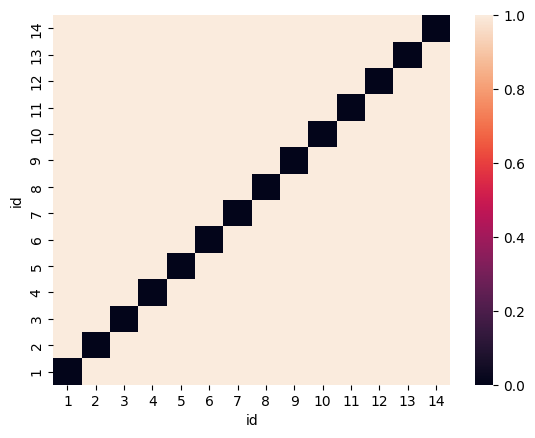

In [15]:
utils.create_contact_matrix(agents=agents, plot=True)

Diese kann nicht nur auf der Ebene der einzelnen Agenten erstellt werden, sondern auch auf der Ebene bestimmter Gruppenmerkmale:

,cheese,pizza
pizza,48,56
cheese,30,48


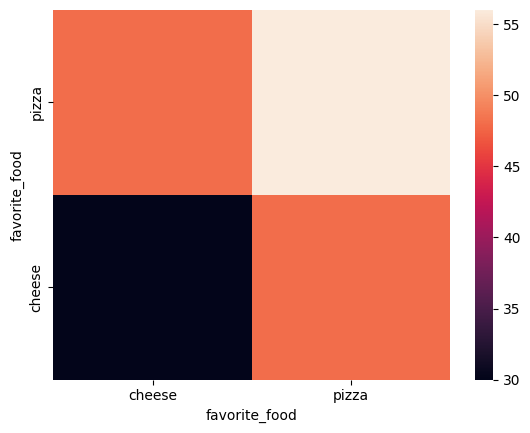

In [16]:
utils.create_contact_matrix(agents=agents, plot=True, attr="favorite_food")

### PopMaker.make(): Agents & Locations in einem Rutsch erstellen

Wir kennen nun die beiden Methoden `PopMaker.create_agents()` und `PopMaker.create_locations()`.
Da wir in Popy sowieso typischerweise sowohl Agents als auch Locations brauchen, gibt es praktische Methode, die beides auf einmal erstellt: `PopMaker.make()`:

In [17]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

Diese Methode hat übrigens noch ein paar weitere praktische Funktionen, die wir etwas später kennenlernen werden.

### Location.join(): Location-Zugang einschränken

Nun wollen wir die Eigenschaften des Restaurants etwas ausweiten.
Mithilfe der Methode `Location.join()` bestimmen wir, dass nur Agenten, deren Alter größer als 30 ist, das Restaurant besuchen.

In [18]:
class Restaurant(popy.Location):
    def join(self, agent):
        return agent.age > 30

In [19]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

Nun sieht das entstehende Netzwerk so aus, da zwei Agenten nicht älter als 30 sind:

In [20]:
graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Location.group(): Agenten gruppieren

Die Methode `Location.group()` ermöglicht es unkompliziert Sub-Locations einer Location zu erstellen.
Für jeden Wert, der pro Agent durch `Location.group()` zurück gegeben wird, wird eine Sub-Location erstellt.
Im Beispiel unten wird nun für jedes Lieblingsessen der Agenten ein eigenes Restaurant geschaffen.

In [21]:
class Restaurant(popy.Location):       
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food

In [22]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="favorite_food")

### Location.setup(): Location-Größe einstellen und vieles mehr

Innerhalb der Methode `Location.setup()` können verschiedene Eigenschaften einer Location bestimmt werden, wie z.B. die Größe `self.size` d.h. die Anzahl der nodes pro Location.
Der `PopMaker` liest diese Werte aus und erstellt dann die benötigte Anzahl der entsprechenden Location.

In [23]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food

In [24]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="favorite_food")

### Location.stick_together(): Agenten zusammen halten

Wenn du dir die Zusammensetzung der Nodes genauer anschaust, fällt dir vielleicht etwas auf: Nicht alle Paare sind jeweils im selben Restaurant.
Wir wollen aber, dass die Agenten jeweils mit ihrem Partner/ihrer Partnerin ins Restaurant gehen.
Um sicherzustellen, dass bestimmte Agenten eine Location auf jeden Fall zusammen besuchen, kann die Methode `Location.stick_together()` verwendet werden.
Alle Agenten, für die die Methode `Location.stick_together()` denselben Wert zurückgibt, besuchen dieselbe Location.
Hier muss allerdings beachtet werden, dass die Methode `Location.stick_together()` in der Hierarchie unter den Methoden `Location.join()` und `Location.group()` steht.

In [25]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id

In [26]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="couple_id")

Wie du siehst, besuchen nun alle Paare zusammen dieselbe Location.

### Location.weight(): Gewichtete Verbindungen erstellen

Die Methode `Location.weight()` ermöglicht es, gewichtete Verbindungen zwischen Agenten zu erzeugen.
Der Wert, der pro Agent durch die Methode `Location.weight()` zurückgegeben wird, bestimmt dabei zunächst die Stärke der Verbindung zwischen dem Agenten und der Location.
Um die Stärke der Verbindung, die zwei Agenten über eine Location zueinander haben, zu ermitteln, wird die Methode `Location.project_weights()` verwendet.
Standardmäßig rechnet diese Methode schlicht den Durchschnitt zwischen dem einen Agenten und der Location sowie zwischen dem anderen Agenten und der Location.
Wie die beiden Gewichte kombiniert werden kann jedoch auch selbst festgelegt werden, indem Methode `Location.project_weights()` entsprechend überschrieben wird.

Unten im Beispiel wird die Stärke eines Agenten zu der von ihm besuchten Restaurant über das Attribut `Agent.time_at_restaurant` bestimmt.
Zur Ermittlung der Verbinungsgewichte zwischen Agenten verwenden wir zunächst die standardmäßige Durchschnittsbildung:

In [27]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant

Wenn du mit der Maus über die Edges fährst, kannst du sehen, dass als Edge-Gewicht jeweils der Durchschnitt der beiden individuellen Gewichte angezeigt wird:

In [28]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="couple_id", edge_alpha="weight", edge_color="black")

### Location.project_weights(): Gewichtung selbst definieren

Interpretieren wir in unserem Beispiel die Gewichte als Zeit, die ein Agent im Restaurant verbringt, dann wäre es unrealistisch, als Gewicht zwischen zwei Agenten den Durchschnitt der Aufenthaltsdauer zu nehmen.
Eine bessere Lösung zur Besimmung der *gemeinsamen Zeit* im Restaurant könnte z.B. sein, jeweils die kürzere der beiden individuellen Aufenthaltszeiten zu nehmen.
Um das umzusetzen, überschreiben wir im Folgenden die Methode `Location.project_weights()`.
Innerhalb unserer eigenen Methode `Location.project_weights()` nutzen wir die Methode `Location.get_weight()`, um das Gewicht eines Agenten zur Location zu ermitteln
(warum man dafür die Methode `Location.get_weight()` verwenden sollte, schauen wir uns später genauer an).

In [29]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant
    
    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2)) / 2

Wir teilen die ermittelte maximale gemeinsame Zeit im Restaurant beispielhaft durch 2, da wir nehmen, dass die Agenten nicht die gesamte Zeit in Kontakt miteinander stehen.

In [30]:
agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="couple_id", edge_alpha="weight", edge_color="black")

### Mehrere Locations erstellen

Bisher existiert nur ein Typ Location.
Eine der Stärken von Popy liegt allerdings darin, dass unkompliziert verschiedene Typen von Locations mit jeweils eigenen Eigenschaften definiert werden können, die die Agenten dann besuchen können.
Gewichtete Verbindungen zwischen Agenten können unkompliziert über alle geteilten Locations berechnet werden.

Im Folgenden wird definieren wir daher eine weitere *Location*: einen Tisch im Restaurant.
An diesem sitzen die jeweiligen Paare.
Schauen wir uns zunächst das Netzwerk an, wenn es nur Tische geben würde:

In [31]:
class Table(popy.Location):
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.couple_id

    def weight(self, agent):
        return agent.time_at_restaurant

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))
    

agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Table])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="couple_id", edge_alpha="weight", edge_color="black")

Nun erstellen wir das Netzwerk basierend auf Restaurants und Tischen.
Um die Verbindung der Agenten innerhalb der Paare nicht doppelt zu zählen, modifizieren wir zusätzlich auch bei der Klasse `Restaurant` die Methode `Restaurant.project_weight()`.

In [32]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant
    
    def project_weights(self, agent1, agent2):
        if agent1.couple_id == agent2.couple_id:
            return 0
        else:
            return min(self.get_weight(agent1), self.get_weight(agent2)) / 2
    

class Table(popy.Location):
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.couple_id

    def weight(self, agent):
        return agent.time_at_restaurant

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))
    

agents, locations = pop_maker.make(df=df, agent_class=Agent, location_classes=[Restaurant, Table])

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="couple_id", edge_alpha="weight", edge_color="black")

### Die Hierarchie der Location-Methoden / -Attribute

`Location.join()` > `Location.group()` > `Location.stick_together()` > `Location.size`

### Beliebig große Populationen erstellen

Bisher haben wir Agenten-Populationen als exakte Kopie des eingegebenen Datensatzes erstellt.
Jede Zeile des Datensatzes wurde dabei in einen Agenten verwandelt.
Popy ermöglicht es jedoch beliebig große Populationen zu erstellen, indem aus dem eingegebenen Datensatz eine Zufallsstichprobe mit Zurücklegen gezogen wird.
Um die gewünschte Größe der Population festzulegen, kann in der Methode `PopMaker.make()` der Parameter `n_agents` verwendet werden.

Im Beispiel unten erstellen wir eine Population der Größe `20`:

In [33]:
agents, locations = pop_maker.make(
    df=df, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table],
    n_agents=20,
    )

Um einen Überblick zu bekommen, wie unsere Agenten-Population aussieht, schauen wir uns diese mithilfe der Funktion `utils.get_df_agents()` als `pd.DataFrame` an:

In [34]:
utils.get_df_agents(agents=agents)

,_var_ignore,id,type,log,model,p,_initial_locations,happiness,age,gender,favorite_food,time_at_restaurant,couple_id
0,[],216,Agent,{},Model,{},[],10,22,m,cheese,1,1
1,[],217,Agent,{},Model,{},"[Restaurant'>-238, Table'>-255]",10,32,m,pizza,2,7
2,[],218,Agent,{},Model,{},"[Restaurant'>-238, Table'>-255]",10,70,w,pizza,1,7
3,[],219,Agent,{},Model,{},[],10,24,w,cheese,1,1
4,[],220,Agent,{},Model,{},"[Restaurant'>-242, Table'>-251]",10,40,m,cheese,3,5
5,[],221,Agent,{},Model,{},[],10,24,w,cheese,1,1
6,[],222,Agent,{},Model,{},"[Restaurant'>-244, Table'>-253]",10,40,w,cheese,5,6
7,[],223,Agent,{},Model,{},"[Restaurant'>-242, Table'>-251]",10,45,w,cheese,3,5
8,[],224,Agent,{},Model,{},"[Restaurant'>-240, Table'>-247]",10,55,w,pizza,2,2
9,[],225,Agent,{},Model,{},[],10,22,m,cheese,1,1


Super, wir haben wie gewünscht eine Population von 20 Agenten.
Spätestens bei einem genaueren Blick auf das Netzwerk unten, sollte dir jedoch etwas auffallen.

In [35]:
graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="couple_id", edge_alpha="weight", edge_color="black")

In unseren Paaren befinden sich nun nicht mehr exakt 2 Agenten.
Dies liegt daran, dass die Zeilen des eingegebenen Datensatzes nicht paarweise, sondern einzeln gesampled wurden.
Das Samplen und erstellen einzelner Agenten kann in manchen Situationen richtig sein, oft wollen wir jedoch zusammengehörende Gruppen von Agenten erstellen - so wie in unserem Beispiel Paare von Agenten.

Um zusammengehörende Gruppen von Agenten zu samplen, kann in der Methode `PopMaker.make()` ein sogenanntes `sample_level` festgelegt werden.
Dadurch wird nicht aus den einzelnen Zeilen des Datensatzes gezogen, sondern aus der Liste aller unterschiedlichen Werte aus der Spalte des Datensatzes, welche durch `sample_level` bestimmt wurde.

Im Beispiel unten setzen wir `sample_level` auf `couple_id`:

In [36]:
agents, locations = pop_maker.make(
    df=df, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table],
    n_agents=20,
    sample_level="couple_id",
    )

Ein Blick auf die Spalte `"couple_id"` zeigt, dass die Agenten nun paarweise gesampled wurden.
Wie du ebenfalls bemerkt haben solltest, haben sich nun jedoch auch die Werte an sich in der Spalte `"couple_id"` verändert.
Jedem gezogenen Paar wurde eine neue, einzigartige `"couple_id` zugewiesen, damit die Paare bei mehrfacher Ziehung noch unterscheidbar sind.
Die ursprünglichen Werte befinden sich nun in der Spalte `"couple_id_orginal`.
Wenn du die Ersetzung der ursprünglichen Werte in der durch `sample_level` definierten Spalte durch neue, einzigartige Werte nicht haben möchtest, kannst du den Parameter `replace_sample_level_column` auf `False` setzen.

In [37]:
utils.get_df_agents(agents=agents)

,_var_ignore,id,type,log,model,p,_initial_locations,happiness,age,gender,favorite_food,time_at_restaurant,couple_id,couple_id_original
0,[],256,Agent,{},Model,{},"[Restaurant'>-284, Table'>-289]",10,50,m,cheese,5,1,6
1,[],257,Agent,{},Model,{},"[Restaurant'>-284, Table'>-289]",10,40,w,cheese,5,1,6
2,[],258,Agent,{},Model,{},"[Restaurant'>-284, Table'>-291]",10,40,m,cheese,3,2,5
3,[],259,Agent,{},Model,{},"[Restaurant'>-284, Table'>-291]",10,45,w,cheese,3,2,5
4,[],260,Agent,{},Model,{},[],10,22,m,cheese,1,3,1
5,[],261,Agent,{},Model,{},[],10,24,w,cheese,1,3,1
6,[],262,Agent,{},Model,{},"[Restaurant'>-286, Table'>-293]",10,50,m,cheese,5,4,6
7,[],263,Agent,{},Model,{},"[Restaurant'>-286, Table'>-293]",10,40,w,cheese,5,4,6
8,[],264,Agent,{},Model,{},"[Restaurant'>-278, Table'>-295]",10,35,m,pizza,2,5,4
9,[],265,Agent,{},Model,{},"[Restaurant'>-278, Table'>-295]",10,34,w,pizza,2,5,4


In [38]:
graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(edge_alpha="weight", edge_color="black")

Manchmal kann es wichtig sein, während dem Sample-Prozess unterschiedliche Auswahlwahrscheinlichkeiten festzulegen.
In der Methode `PopMaker.make()` kann über den Parameter `sample_weight` eine Spalte im `df` bestimmt werden, die die Gewichte enthält.

Übrigens: das Sampling innerhalb der Methode `PopMaker.make()` wird intern von der Methode `PopMaker.draw_sample()` übernommen.
Du kannst diese Methode auch einzeln benutzen, um z.B. den gesampleten Datensatz vor dessen Übersetzung in Agenten nochmal bearbeiten zu können.

In [39]:
df_sample = pop_maker.draw_sample(df=df, n=20, sample_level="couple_id")

df_sample["friend_group_id"] = df_sample.couple_id.apply(lambda x: 1 if x <= 5 else 2)
df_sample

,age,gender,favorite_food,time_at_restaurant,couple_id,couple_id_original,friend_group_id
0,50,m,cheese,5,1,6,1
1,40,w,cheese,5,1,6,1
2,40,m,cheese,3,2,5,1
3,45,w,cheese,3,2,5,1
4,70,m,pizza,1,3,3,1
5,33,w,pizza,2,3,3,1
6,40,m,cheese,3,4,5,1
7,45,w,cheese,3,4,5,1
8,50,m,cheese,5,5,6,1
9,40,w,cheese,5,5,6,1


In [40]:
class Restaurant(popy.Location):
    def setup(self):
        self.size = 4
        
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.favorite_food
    
    def stick_together(self, agent):
        return agent.couple_id
    
    def weight(self, agent):
        return agent.time_at_restaurant
    
    def project_weights(self, agent1, agent2):
        if agent1.couple_id == agent2.couple_id:
            return 0
        else:
            return min(self.get_weight(agent1), self.get_weight(agent2)) / 2
    

class Table(popy.Location):
    def join(self, agent):
        return agent.age > 30
    
    def group(self, agent):
        return agent.couple_id

    def weight(self, agent):
        return agent.time_at_restaurant

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))


class Friends(popy.Location):
    def group(self, agent):
        return agent.friend_group_id
    

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table, Friends],
    sample_level="couple_id"
    )

graph = utils.create_agent_graph(agents, node_attrs=df_sample.columns)
graph_layout = nx.drawing.spring_layout(graph)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(node_color="friend_group_id", edge_alpha="weight", edge_color="black")

In [41]:
utils.eval_affiliations(agents, locations)



______________________________________
Number of agents per location
______________________________________

               n_agents                                              
                  count  mean       std   min   25%   50%   75%   max
location_class                                                       
Friends             2.0  10.0  0.000000  10.0  10.0  10.0  10.0  10.0
Restaurant          5.0   3.6  0.894427   2.0   4.0   4.0   4.0   4.0
Table               9.0   2.0  0.000000   2.0   2.0   2.0   2.0   2.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    20.000000
mean      2.800000
std       0.615587
min       1.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       3.000000
Name: n_affiliated_locations, dtype: float64


In [42]:
agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[Restaurant, Table, Friends],
    n_agents=100,
    sample_level="couple_id",
    )

graph = utils.create_agent_graph(agents, node_attrs=df_sample.columns)
graph_layout = nx.drawing.spring_layout(graph)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(node_color="friend_group_id", edge_alpha="weight", edge_color="black")

### Bestimmte Netzwerksturkturen erzeugen

Bisher erzeugen wir die Struktur unseres Netzwerkes anhand eines einfachen Prinzipes:
Sofern keine weiteren Bedinungen bestimmt wurden, werden stets alle Agenten, die auf einem durch die Location definierten Attribut denselben Werte aufweisen, werden über die Location verbunden.
Eine einzelne Location kann daher immer nur eine relativ simple Netzwerk erzeugen:
Entweder ein vollverbundenes Netzwerk oder mehrere kleinere, unverbundene vollverbundene Netzwerke.
Durch die Definition mehrerer Locations können allein durch dieses simple Prinzip relativ komplexe und realistische Netzwerk- bzw. Sozialstrukturen erzeugt werden.
Manchmal kann es jedoch sinnvoll sein, innerhalb einer Location kein vollverbundenes Netzwerk vorliegen zu haben, sondern eine andere spezifische Netzwerkstruktur.
Auch das kann prinzipiell mit Popy umgesetzt werden.

Am Beispiel eines einfachen Ring-Netzwerkes schauen wir uns im Folgenden an, wie in der *Popy-Logik* eine spezifische Netzwerkstruktur mithilfe der Methode `Location.group()` erstellt werden kann.
Da es bei der Verwendung von `group()` jedoch für solche Zwecke schnell Grenzen erreicht sind, schauen wir uns danach eine für solche Zwecke besser geeignete Methode an: die Methode `Location.subgroup()`.


In [43]:
class LargeLoop(popy.Location):
    def group(self, agent):
        pos = self.model.agents.index(agent)
        right = (pos + 1) % len(self.model.agents)
        return [pos, right]

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[LargeLoop],
    n_agents=15,
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Location.subgroup(): Subgruppen definieren

`Location.subgroup()` funktioniert im Prinzip wie die Methode `Location.group()`...


In [44]:
class LargeRing(popy.Location):
    def subgroup(self, agent):
        pos = self.group_agents.index(agent)
        right = (pos + 1) % len(self.group_agents)
        return [pos, right]

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[LargeRing],
    n_agents=15,
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw()

### Klassische Netzwerktopologien

#### Vollvernetzt

In [45]:
class FullyConnected(popy.Location):
    def setup(self):
        self.size = 6

    def group(self, agent):
        return agent.favorite_food

    def stick_together(self, agent):
        return agent.couple_id

agents, locations = pop_maker.make(
    df=df_sample,
    agent_class=Agent,
    location_classes=[FullyConnected],
    n_agents=50,
    sample_level="couple_id"
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="favorite_food")

#### Linie

In [46]:
class Line(popy.Location):
    def setup(self):
        self.size = 6

    def group(self, agent):
        return agent.favorite_food

    def subgroup(self, agent):
        pos = self.group_agents.index(agent)
        right = (pos + 1)
        return [pos, right]

    def stick_together(self, agent):
        return agent.couple_id

agents, locations = pop_maker.make(
    df=df_sample,
    agent_class=Agent,
    location_classes=[Line],
    n_agents=50,
    sample_level="couple_id"
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="favorite_food")

#### Ring

In [47]:
class Ring(popy.Location):
    def setup(self):
        self.size = 6

    def group(self, agent):
        return agent.favorite_food

    def subgroup(self, agent):
        pos = self.group_agents.index(agent)
        right = (pos + 1) % len(self.group_agents)
        return [pos, right]

    def stick_together(self, agent):
        return agent.couple_id

agents, locations = pop_maker.make(
    df=df_sample,
    agent_class=Agent,
    location_classes=[Ring],
    n_agents=50,
    sample_level="couple_id"
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="favorite_food")

#### Grid

In [48]:
class Grid(popy.Location):
    def setup(self):
        self.row_len = 3
        self.size = int(self.row_len*self.row_len)
        self.right_edge_positions = [self.row_len * i - 1 for i in range(self.row_len)]
        
    def group(self, agent):
        return agent.favorite_food

    def subgroup(self, agent):
        pos = self.group_agents.index(agent)
        right = pos + 1
        left = pos - 1
        top = pos - self.row_len
        bottom = pos + self.row_len

        return_list = []
        return_list.append("-".join(sorted([str(pos), str(left)])))
        return_list.append("-".join(sorted([str(pos), str(top)])))
        return_list.append("-".join(sorted([str(pos), str(bottom)])))
        if pos not in self.right_edge_positions:
            return_list.append("-".join(sorted([str(pos), str(right)])))
        
        return return_list

agents, locations = pop_maker.make(
    df=df_sample, 
    agent_class=Agent, 
    location_classes=[
        Grid,
        ],
    n_agents=100,
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.draw(node_color="favorite_food")

#### Proximity-Netzwerk

In [49]:
import random
import math
import networkx as nx

class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs) -> None:
        super().__init__(model, *args, **kwargs)
        self.x_pos = random.randint(0, 10)
        self.y_pos = random.randint(0, 10)
        self.location_codes = []
    
    def get_distance(self, agent):
        return math.sqrt((agent.x_pos - self.x_pos)**2 + (agent.y_pos - self.y_pos)**2)

    def create_location_code(self, agent):
        if agent is not self:
            if self.get_distance(agent) <= 4:
                location_code = "-".join(sorted([str(self.id), str(agent.id)]))
                self.location_codes.append(location_code)
        

class SpacialProximity(popy.Location):
    def setup(self):
        self.size = 20

    def group(self, agent):
        return agent.gender
    
    def subgroup(self, agent):
        for agent_v in self.group_agents:
            agent.create_location_code(agent_v)
        return agent.location_codes

agents, locations = pop_maker.make(
    df=df_sample,
    agent_class=Agent, 
    location_classes=[SpacialProximity],
    n_agents=100,
    )

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
graph_layout = nx.drawing.spring_layout(graph)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(node_color="gender")

#### Stern (mittels Gewichtung)

In [50]:
class Star(popy.Location):
    def setup(self):
        self.size = 5

    def join(self, agent):
        return agent.favorite_food == "pizza"
    
    def do_this_after_creation(self):
        for agent in self.model.agents:
            if agent.favorite_food == "cheese":
                if not hasattr(agent, "picked") or hasattr(agent, "picked") and not agent.picked:
                    self.add_agent(agent)
                    agent.picked = True
                    break
    
    def project_weights(self, agent1, agent2):
        if agent1.favorite_food == agent2.favorite_food:
            return 0
        else:
            return 10

agents, locations = pop_maker.make(
    df=df,
    agent_class=Agent,
    location_classes=[Star],
    n_agents=30,
)

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
graph_layout = nx.drawing.spring_layout(graph,)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(node_color="favorite_food", edge_alpha="weight", edge_color="black")

#### Stern

In [51]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs) -> None:
        super().__init__(model, *args, **kwargs)
        self.waiter = False

class Star(popy.Location):
    def setup(self):
        self.size = 5
        self.has_cheese_agent = False

    def join(self, agent):
        return agent.favorite_food == "pizza"
        
    def subgroup(self, agent):
        return agent.id
    
    def do_this_after_creation(self):
        subgroup_locations = [location for location in self.model.locations if location.group_id == self.group_id]
        if not self.has_cheese_agent:
            for agent in self.model.agents:
                if agent.favorite_food == "cheese" and not agent.waiter:
                    agent.waiter = True
                    for location in subgroup_locations:
                        location.add_agent(agent)
                        location.has_cheese_agent = True
                    break
            
agents, locations = pop_maker.make(
    df=df,
    agent_class=Agent,
    location_classes=[Star],
    n_agents=100,
)

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
graph_layout = nx.drawing.spring_layout(graph,)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(node_color="favorite_food", edge_alpha=0.3, edge_color="black")

#### Baum

In [52]:
class Tree(popy.Location):
    def group(self, agent):
        return agent.favorite_food
    
    def subgroup(self, agent):
        # agent 0:
        self.infected = True
        if not hasattr(agent, "contacts"):
            agent.contacts = [agent]

        for a in self.group_agents:
            if not hasattr(a, "infected") or hasattr(a, "infected") and not a.infected:
                if agent is not a:
                    agent.contacts.append(a)
                    if hasattr(a, "contacts"):
                        a.contacts.append(agent)
                    else:
                        a.contacts = [agent]
                    a.infected = True
            if len(agent.contacts) >= 4:
                break
        
        location_ids = ["-".join(sorted([str(agent.id), str(a.id)])) for a in agent.contacts]
        return location_ids

            
    
agents, locations = pop_maker.make(
    df=df,
    agent_class=Agent,
    location_classes=[Tree],
    n_agents=100,
)

graph = utils.create_agent_graph(agents, node_attrs=df.columns)
graph_layout = nx.drawing.spring_layout(graph,)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(node_color="favorite_food", edge_alpha=0.3, edge_color="black")

### Multi-Level-Clusterung

In [53]:
class Town(popy.Location):
    def setup(self):
        self.size = 12

    def group(self, agent):
        return agent.favorite_food
    
    def weight(self, agent):
        return 1

class School(popy.Location):
    def setup(self):
        self.size = 6

    def nest(self):
        return Town
    
    def weight(self, agent):
        return 10

class Class(popy.Location):
    def setup(self):
        self.size = 3

    def nest(self):
        return School
    
    def weight(self, agent):
        return 20


agents, locations = pop_maker.make(
    df=df,
    agent_class=Agent,
    location_classes=[Town, School, Class],
    n_agents=30,
)

for agent in agents:
    agent._initial_locations = "".join(agent._initial_locations)
attrs = list(df.columns)
attrs.append("_initial_locations")
graph = utils.create_agent_graph(agents, node_attrs=attrs)
graph_layout = nx.drawing.spring_layout(graph,)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(
    node_color="_initial_locations", 
    edge_alpha="weight", 
    edge_color="black",
    )

In [77]:
class Town(popy.Location):
    def setup(self):
        self.size = 10

    def group(self, agent):
        return agent.favorite_food
    
    def weight(self, agent):
        return 1

    def join(self, agent):
        return agent.gender == "w"

class School(popy.Location):
    def setup(self):
        self.size = 5

    def nest(self):
        return Town
    
    def weight(self, agent):
        return 10

    def join(self, agent):
        return agent.gender == "w"

class Class(popy.Location):
    def setup(self):
        self.size = 3

    def nest(self):
        return School
    
    def weight(self, agent):
        return 20

agents, locations = pop_maker.make(
    df=df,
    agent_class=Agent,
    location_classes=[Town, School],
    n_agents=20,
)

for agent in agents:
    agent._initial_locations = "".join(agent._initial_locations)
attrs = list(df.columns)
attrs.append("_initial_locations")
graph = utils.create_agent_graph(agents, node_attrs=attrs)
graph_layout = nx.drawing.spring_layout(graph,)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(
    node_color="_initial_locations", 
    edge_alpha="weight", 
    edge_color="black",
    )

In [74]:
class Town(popy.Location):
    def setup(self):
        self.size = 16

    def group(self, agent):
        return agent.favorite_food
    
    def weight(self, agent):
        return 1

    def subgroup(self, agent):
        pos = self.group_agents.index(agent)
        right = (pos + 1)
        return [pos, right]

class School(popy.Location):
    def setup(self):
        self.size = 8

    def nest(self):
        return Town
    
    def weight(self, agent):
        return 10

    def subgroup(self, agent):
        pos = self.group_agents.index(agent)
        right = (pos + 1)
        return [pos, right]



agents, locations = pop_maker.make(
    df=df,
    agent_class=Agent,
    location_classes=[Town, School, Class],
    n_agents=48,
)

for agent in agents:
    agent._initial_locations = "".join(agent._initial_locations)
attrs = list(df.columns)
attrs.append("_initial_locations")
graph = utils.create_agent_graph(agents, node_attrs=attrs)
graph_layout = nx.drawing.spring_layout(graph,)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(
    node_color="favorite_food", 
    edge_alpha="weight", 
    edge_color="black",
    )

C:\01-main\ac135963\Projekte\popy\src\popy\pop_maker.py:194: UserWarning: For agent Agent (Obj 9090),
                            2 locations of class 
                            <class '__main__.Town'> were found as potential mothers of 
                            School (Obj 9159) in the list of locations.
  warnings.warn(
C:\01-main\ac135963\Projekte\popy\src\popy\pop_maker.py:194: UserWarning: For agent Agent (Obj 9091),
                            2 locations of class 
                            <class '__main__.Town'> were found as potential mothers of 
                            School (Obj 9159) in the list of locations.
  warnings.warn(
C:\01-main\ac135963\Projekte\popy\src\popy\pop_maker.py:194: UserWarning: For agent Agent (Obj 9092),
                            2 locations of class 
                            <class '__main__.Town'> were found as potential mothers of 
                            School (Obj 9159) in the list of locations.
  warnings.warn(
C:\01-main\ac

Vermutlich erfolgt die Linien-Verbindung der Stadt und der Schule über dieselbe Person, weil die Agenten immer in der gleichen Reihenfolge in den entsprechenden Listen vorliegen. Man könnte die Agenten jedes mal mischen ...

## Die Netzwerke in einer Simulation nutzen

Bisher haben uns angeschaut, wie wir mithilfe von Locations Verbindungen zwischen Agenten herstellen können und so ein quasi statisches Netzwerk schaffen.
Dieses Netzwerk kann an sich bereits genutzt werden und beispielsweise als [Networkx-Graph](https://networkx.org/) exportiert werden.
Die erstellten Netzwerke können jedoch auch direkt mithilfe von Popy in agentenbasierten Simulationen eingesetzt werden.
Popy basiert hier fast vollständig auf dem ABM-Framework [AgentPy](https://agentpy.readthedocs.io/en/latest/#).
Popy erweitert diesen Ansatz jedoch um die Integration der definierten Locations.

Im Folgenden Beispiel programmieren wir Schritt für Schritt eine Infektionssimulation.

### DataFaker

Damit wir uns nicht wieder einen Datensatz ausdenken müssen, nutzen wir diesmal ein weiteres nützliches Feature von Popy: den `data_faker`.
Der `data_faker` erstellt uns einen beliebig großen Datensatz, welcher einem klassischen Survey-Datensatz ähnelt.
Der `data_faker.soep_faker` ist dabei in Form und Inhalt an das Sozio-Ökonomische Panel angelehnt.

Unten erstellen wir beispielhaft einen Datensatz mit 50 Zeilen:

In [56]:
from popy.data_fakers.soep import soep_faker

df_soep = soep_faker.soep(size=1000)
df_soep.head()

,age,gender,work_hours_day,nace2_division,hid,pid
0,61.0,male,0.000000,-2,9399,8159
1,49.0,female,7.458731,56,9399,1929
2,99.0,male,7.859219,99,234,8168
3,65.0,male,4.261473,27,234,9608
4,57.0,male,5.654764,88,1662,1307


### Ein erstes Modell

Zentral bei der Implementierung eines Simulationsmodells mit Popy bzw. AgentPy ist die `Model`-Klasse.
Jede Simulation benötigt ein Objekt dieser Klasse.
Das `Model`-Objekt beinhaltet alle Bestandteile der Simulation (z.B. Agents, Locations) und definiert die Abläufe der Simulation.

Ein `Model`-Objekt verfügt standardmäßig über vier zentrale Methoden, in denen wir die grundlegenden Abläufe der Simulation definieren:
1. `Model.setup()`
2. `Model.step()`
3. `Model.update()`
4. `Model.end()`

Für genauere Informationen über den Sinn und Zweck der einzelnen Methoden, schau am besten direkt in die Dokumentation von AgentPy: https://agentpy.readthedocs.io/en/latest/reference_model.html.

Neben einer *leeren* `Agent`-Klasse und einer *leeren* `Location`-Klasse definieren wir unten unsere erste eigene `Model`-Klasse.
Zunächst defineren die Methode `setup()`, welche nach der AgentPy-Logik zu Beginn der Simulation ausgeführt wird.
Innerhalb der Methode `setup()` machen wir zunächst nichts weiter als wie gewohnt einen `PopMaker` zu erstellen und dann Agenten und Locations zu erschaffen.
Diesmal speichern wir jedoch alles jeweils als Attribute des `InfectionModel`.
Zudem ist wichtig, das `InfectionModel` in der Form von `self` über den Parameter `model` an den `PopMaker` zu übergeben.
Das stellt sicher, dass alle über diesen `PopMaker` erstellten Agenten und Locations dem `InfectionModel` zugewiesen werden und andersherum.
Dadurch können z.B. Agenten während der Simulation auf ihre Umgebung zugreifen.

In [57]:
class Agent(popy.Agent):
    pass

class Home(popy.Location):
    pass

class InfectionModel(popy.Model):
    def setup(self):
        self.pop_maker = PopMaker(model=self)
        self.agents = pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = pop_maker.create_locations(agents=self.agents, location_classes=[Home])

Unten lassen wir das Simulationsmodell laufen.
Schau auch hier am besten wieder in die Dokumentation von AgentPy, um den Code besser zu verstehen: https://agentpy.readthedocs.io/en/latest/overview.html#running-a-simulation

In [58]:
parameters = {
    "steps": 50,
}
model = InfectionModel(parameters=parameters)
results = model.run()

Completed: 50 steps
Run time: 0:00:00.583158
Simulation finished


Die Simulation ist gelaufen, aber es ist praktisch nichts passiert, außer dass die Agenten und Locations erstellt wurden.
Das Objekt `model` verfügt jetzt z.B. über das Attribut `agents`:

In [59]:
model.agents

AgentList (1000 objects)

In [60]:
model.locations

LocationList (1 object)

Im Folgenden bauen wir die Infektionssimulation etwas aus.
Dem Agenten fügen wir die Attribute `infection_status` und `days_since_infection` sowie die Methoden `infect` und `update_infection_status` hinzu.

Relevant ist hier einerseits, wie der Agent auf andere Agenten, mit denen er in Kontakt steht, zugreift.
Dies geschieht mithilfe der Methode `Agent.neighbors()`.
Andererseits ist relevant, wie der Agent ermittelt, *wie viel* Kontakt er zu den anderen Agenten hat bzw. hatte.
Dies geschieht mithilfe der Methode `Agent.contact_weight()`.
Beide Methoden beziehen jeweils alle Locations ein, die ein Agent besucht.


In [61]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors():
                if agent_v.infection_status == "susceptible":
                    contact_weight = self.contact_weight(agent_v)
                    infection_probability = 0.01 * contact_weight

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"


    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"

            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

Unten definieren wir 4 Locations.
Ein Zuhause `Home`, dem jeweils alle Agenten eines Haushaltes zugeordnet werden, eine Arbeitsstelle `Work`, die die Agenten nach ihren beruflichen Sektoren gruppiert und eine Schule `School`, die altersspezifische Klassen enthält.
Damit jeder Agent mindestens zu zwei anderen Agenten Kontakt hat, definieren wir noch die Location  `Ring`, die die gesamte Population entlang eines Rings verbindet.

In [62]:
class Home(popy.Location):
    def group(self, agent):
        return agent.hid

    def weight(self, agent):
        return 12

class Work(popy.Location):
    def setup(self):
        self.size = 10

    def join(self, agent):
        return True if agent.work_hours_day > 0 and agent.nace2_division > 0 else False

    def group(self, agent):
        return agent.nace2_division

    def weight(self, agent):
        return agent.work_hours_day

class School(popy.Location):
    def setup(self):
        self.size = 25

    def join(self, agent):
        return True if 6 <= agent.age <= 18 else False
    
    def group(self, agent):
        return agent.age

    def weight(self, agent):
        return 6

class Ring(popy.Location):
    def subgroup(self, agent):
        pos = self.model.agents.index(agent)
        right = (pos + 1) % len(self.model.agents)
        return [pos, right]

Das `InfectionModel` erweitern wir insofern, dass in `setup()` zu Beginn der Simulation 10 zufällige Agenten angesteckt werden.
In `step()` legen wir fest, was in jedem einzelnen Zeitschritt der Simulation passieren soll.
Zunächst soll für jeden Agenten die Methode `update_infection_status()` ausgeführt werden und dann für jeden Agenten die Methode `infect()`.
Falls du dich über die komische Syntax wunderst, schau doch mal [hier](https://agentpy.readthedocs.io/en/latest/overview.html#agent-sequences).
Die Methode `update()` wird ebenfalls in jedem Zeitschritt ausgeführt, jedoch immer nach der Methode `step()`.
In `update()` sammeln wir die Anzahl der jemals infizierten Agenten, um diese nach der Simulation pro Zeitschritt zu visualisieren.

In [63]:
class InfectionModel(popy.Model):
    def setup(self):
        self.pop_maker = PopMaker(model=self)
        self.agents = pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = pop_maker.create_locations(
            agents=self.agents, 
            location_classes=[
                Home, 
                Work, 
                School, 
                Ring,
                ])

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"
    
    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )

Wir lassen das Modell laufen:

In [64]:
parameters = {
    "steps": 50,
}
model = InfectionModel(parameters=parameters)
results = model.run()


Completed: 50 steps
Run time: 0:00:11.164194
Simulation finished


Unten sehen wir die Anzahl der kumulierten Infektionen pro Simulationsschritt:

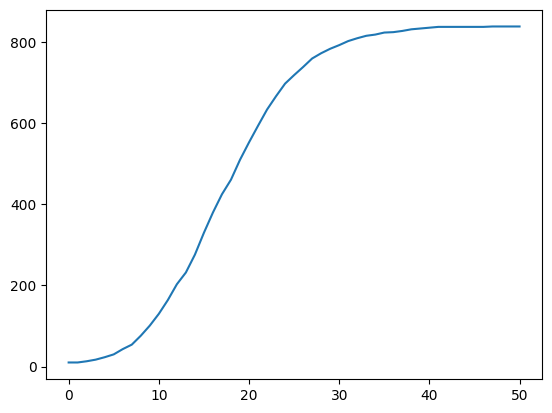

In [65]:
import matplotlib.pyplot as plt

plt.plot(results.variables.InfectionModel.cumulative_infections)

In [66]:
graph = utils.create_agent_graph(model.agents, node_attrs=df_soep.columns)
graph_layout = nx.drawing.spring_layout(graph)
plot = BokehGraph(graph, width=400, height=400, hover_edges=True)
plot.layout(layout=graph_layout)
plot.draw(edge_alpha="weight", edge_color="black", node_size=4, edge_size=0.5)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0
99.0,0,0,25,0,0,0,0,12,0,1,...,0.0,0.000000,0.0,0.000000,13.000000,0.000000,7.77094,0.0,0.0,0.00000
98.0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,13.0,0.000000,1.000000,13.000000,0.00000,0.0,0.0,0.00000
97.0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,8.328067,0.000000,0.000000,0.00000,0.0,0.0,0.00000
96.0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,7.77094
95.0,0,0,0,12,0,25,0,0,12,0,...,0.0,7.719427,0.0,0.000000,7.719427,8.407506,0.00000,0.0,13.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.0,0,13,0,13,0,25,0,0,13,0,...,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00000
3.0,0,13,0,0,13,12,0,12,0,0,...,0.0,0.000000,0.0,0.000000,0.000000,12.000000,0.00000,0.0,0.0,0.00000
2.0,0,12,0,0,0,0,0,25,13,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,25.00000
1.0,0,0,12,13,13,0,0,26,13,13,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.00000


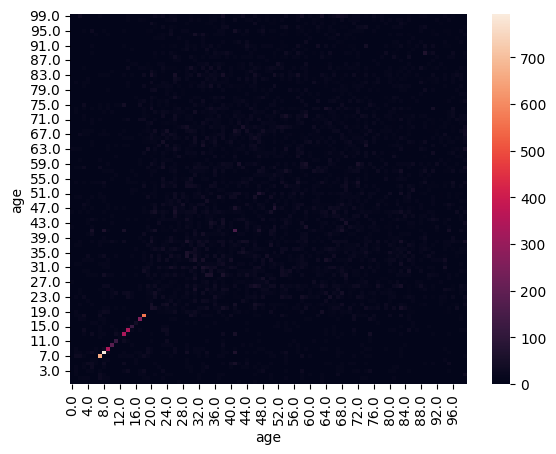

In [67]:
utils.create_contact_matrix(agents=model.agents, attr="age", plot=True, weighted=True)

### utils.group_it(): Werte unkompliziert gruppieren

,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
95,37,50,36,29.565571,159.357005,138.185771,45.370067,196.083566,147.144321,152.978529,147.600779,128.937481,163.531730,232.821754,220.050570,106.015051,113.785653,91.392189,50.766921,49.949386
90,1,40,12,17.513786,76.277069,129.136742,212.295853,94.610608,135.880068,82.507278,85.238009,106.774575,89.391967,124.320170,95.799748,18.164307,108.809528,120.137102,97.412014,50.766921
85,12,14,39,64.232484,103.685222,128.571556,197.563265,234.116588,105.436886,162.833363,193.547093,156.093650,70.035670,127.805900,111.367470,82.226429,93.011651,176.006514,120.137102,91.392189
80,63,37,54,72.819551,238.636087,199.352249,246.703741,307.214981,142.525101,209.197648,134.493481,184.287766,132.682330,126.612223,178.850707,96.081705,185.897673,93.011651,108.809528,113.785653
75,27,37,63,76.816330,205.594954,111.191981,131.867700,147.566283,138.558268,126.221782,106.648663,157.331221,62.004322,165.854380,117.085459,92.499951,96.081705,82.226429,18.164307,106.015051
70,61,88,50,117.908587,198.399345,215.207927,196.738403,265.744635,183.692470,224.114188,224.562229,263.886108,198.766256,232.030406,188.484899,117.085459,178.850707,111.367470,95.799748,220.050570
65,74,74,49,97.035575,308.879548,249.344432,273.966026,285.475660,334.421251,347.688287,232.943543,120.329836,197.546491,218.474902,232.030406,165.854380,126.612223,127.805900,124.320170,232.821754
60,49,50,50,83.202438,187.353633,206.620290,186.167633,121.209881,127.093552,224.622803,159.108192,195.273569,92.331133,197.546491,198.766256,62.004322,132.682330,70.035670,89.391967,163.531730
55,51,64,53,66.444356,205.761459,174.786497,279.022599,223.910965,199.972328,208.283137,269.232867,241.020454,195.273569,120.329836,263.886108,157.331221,184.287766,156.093650,106.774575,128.937481
50,50,128,12,138.280073,180.110696,276.544688,241.601452,223.839709,273.651242,242.304916,217.681443,269.232867,159.108192,232.943543,224.562229,106.648663,134.493481,193.547093,85.238009,147.600779


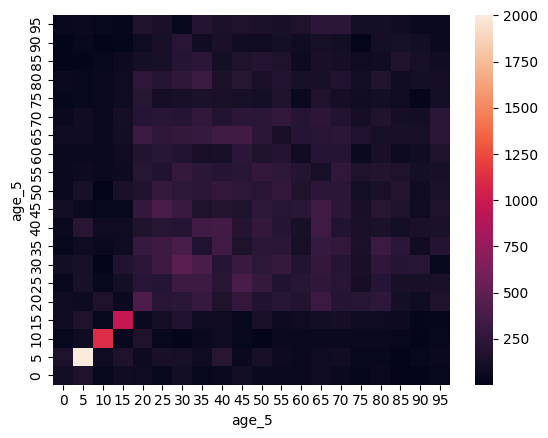

In [68]:
for agent in model.agents:
    agent.age_5 = utils.group_it(agent.age, start=0, step=5, n_steps=20, return_value="lower_bound")

utils.create_contact_matrix(agents=model.agents, attr="age_5", plot=True, weighted=True)

## Dynamische Netzwerke

Bisher haben wir rein statische Netzwerke, die sich nach ihrer Erstellung nicht mehr verändert haben.
In Popy gibt es zwei Wege die Netzwerke während der Simulation zu verändern.
Zum einen können Agenten mithilfe der Methoden `Location.remove_agent()` und `Location.add_agent()` Locations verlassen und beitreten.
Falls ein kompletter *Umzug* des Agenten von der einen zur anderen Location nicht notwendig ist, können zum anderen auch einfach die Verbindungsgewichte zwischen dem Agenten und der Location variiert werden.
Dieser Weg ist, wenn möglich, immer vorzuziehen.

Beginnend mit der *dynamischen Gewichtung*, schauen wir uns im Folgenden beide Wege der Erschaffung dynamischer Netzwerke an.

### Dynamische Gewichtung

Wir wollen die Infektionssimulation nun um eine weitere Eigenschaften erweitern: Agenten besuchen die Schule oder Arbeitsstelle nur, wenn diese nicht gerade symptomatisch krank sind

Um die Agenten, die symptomatisch krank sind, von Schulen und Arbeitsstellen ausszuschließen, passen wir jeweils die Methode `weight()` an.
Die Methode `weight()` wird standardmäßig in jedem Zeitschritt für jede Location immer wieder ausgeführt, sodass die Gewichte stets aktuell sind
(da dies die Performance der Simulation beeinträchtigen kann, kann man in der Methode `setup()` das Attribute `Location.static_weight = True` setzen, um diese Funktionsweise zu deaktivieren).

In [69]:
class Home(popy.Location):
    def group(self, agent):
        return agent.hid

    def weight(self, agent):
        return 12

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))

class Work(popy.Location):
    def setup(self):
        self.size = 10

    def join(self, agent):
        return True if agent.work_hours_day > 0 and agent.nace2_division > 0 else False

    def group(self, agent):
        return agent.nace2_division

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 0
        else:
            return agent.work_hours_day
    
    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))

class School(popy.Location):
    def setup(self):
        self.size = 25

    def join(self, agent):
        return True if 6 <= agent.age <= 18 else False
    
    def group(self, agent):
        return agent.age

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 0
        else:
            return 6
        
    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))

class Ring(popy.Location):
    def subgroup(self, agent):
        pos = self.model.agents.index(agent)
        right = (pos + 1) % len(self.model.agents)
        return [pos, right]

In [70]:
import datetime as dt

class InfectionModel(popy.Model):
    def setup(self):
        self.pop_maker = PopMaker(model=self)
        self.agents = pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = pop_maker.create_locations(
            agents=self.agents, 
            location_classes=[
                Home, 
                Work, 
                School, 
                Ring,
                ])
        self.date = dt.date(2022, 1, 1)

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"
    
    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )

In [71]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors():
                if agent_v.infection_status == "susceptible":
                    contact_weight = self.contact_weight(agent_v)
                    infection_probability = 0.01 * contact_weight

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"


    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 1 <= self.days_since_infection <= 2:
                self.infection_status = "infectious"

            elif 3 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [72]:
parameters = {
    "steps": 50,
}
model = InfectionModel(parameters=parameters)
results = model.run()


Completed: 50 steps
Run time: 0:00:11.988084
Simulation finished


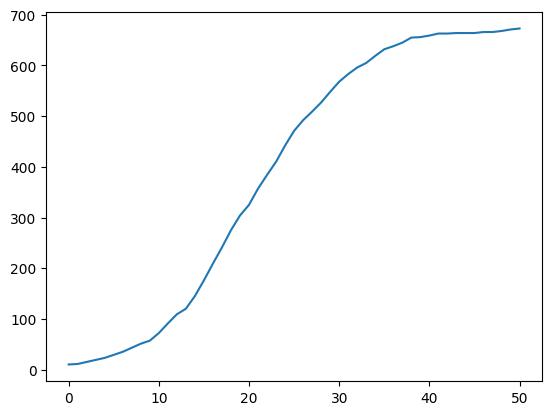

In [73]:
import matplotlib.pyplot as plt

plt.plot(results.variables.InfectionModel.cumulative_infections)